In [19]:

# Importing libraries

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import time
import psutil
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from codecarbon import EmissionsTracker
import os
import warnings
import nbformat

In [20]:
# Suppress warnings 
warnings.filterwarnings("ignore")
os.environ["TOKENIZERS_PARALLELISM"] = "false" # Suppress Hugging Face parallelism warnings

In [21]:
# Setting random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [22]:
# Device configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")
print(f"PyTorch version: {torch.__version__}")
print(f"Supported quantization engines: {torch.backends.quantized.supported_engines}")

Using device: cpu
PyTorch version: 2.8.0
Supported quantization engines: ['qnnpack', 'none']


In [23]:
# --- CodeCarbon Configuration ---
if not os.path.exists(".codecarbon.config"):
    with open(".codecarbon.config", "w") as f:
        f.write("[codecarbon]\nmeasure_power_secs=0.1\ncpu_power=35\n")  # TDP for Intel i7

In [24]:
# --- Model Selection ---
models = {
    'BERT-base': 'bert-base-uncased',
    'DistilBERT': 'distilbert-base-uncased'
}

In [25]:
# --- Dataset Preparation ---
train_dataset = load_dataset("glue", "sst2", split="train[:10%]")  # 10% for quick fine-tuning
eval_dataset = load_dataset("glue", "sst2", split="validation")  # Full validation set

In [26]:
# Load models and tokenizers, fine-tune
loaded_models = {}
tokenizers = {}
for name, path in models.items():
    tokenizers[name] = AutoTokenizer.from_pretrained(path)
    model = AutoModelForSequenceClassification.from_pretrained(path, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [27]:
# Tokenize datasets
def tokenize_function(examples):
    return tokenizers[name](examples["sentence"], padding="max_length", truncation=True, max_length=128, return_tensors="pt")
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_eval = eval_dataset.map(tokenize_function, batched=True)
tokenized_train.set_format("torch", columns=["input_ids", "attention_mask", "label"])
tokenized_eval.set_format("torch", columns=["input_ids", "attention_mask", "label"])

Map: 100%|██████████| 872/872 [00:00<00:00, 10228.98 examples/s]


In [36]:
# Convert to DataFrame
df = pd.DataFrame(results)
df.to_csv("quantisation_results.csv", index=False)
print("\nResults Summary:")
print(df.round(4))


Results Summary:
        Model Quantized  Accuracy  Latency_ms  Memory_MB  ModelSize_MB  \
0   BERT-base      FP32      0.49     52.1898   508.5312      417.7102   
1   BERT-base      INT8      0.54     92.6762  -240.4844      173.0713   
2  DistilBERT      FP32      0.46     22.1807   181.7500      255.4450   
3  DistilBERT      INT8      0.48     45.5718  -167.2500      132.2808   

   Emissions_kg  
0           0.0  
1           0.0  
2           0.0  
3           0.0  


In [17]:
# --- Visualizations ---
sns.set(style="whitegrid", palette="muted", font_scale=1.2)

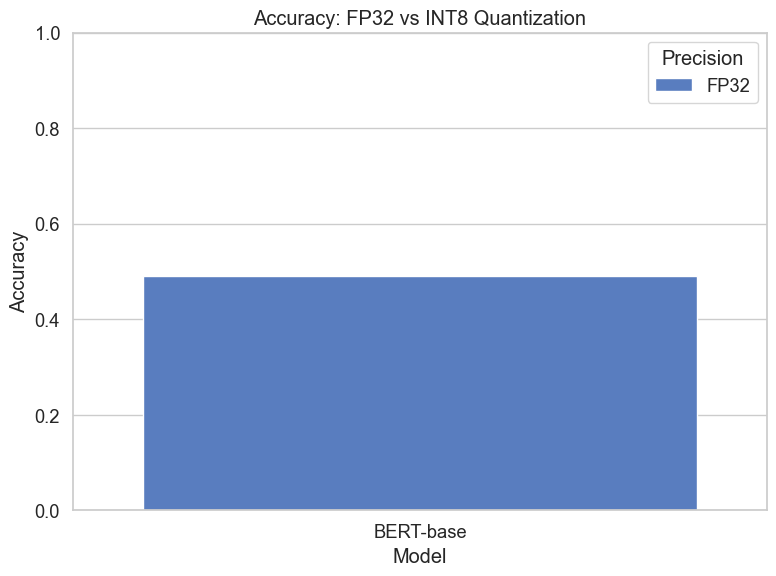

In [18]:
# 1. Accuracy Comparison
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x="Model", y="Accuracy", hue="Quantized")
plt.title("Accuracy: FP32 vs INT8 Quantization")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend(title="Precision")
plt.tight_layout()
plt.savefig("accuracy_comparison.png", dpi=300)
plt.show()

In [ ]:
# 2. Latency Comparison
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x="Model", y="Latency_ms", hue="Quantized")
plt.title("Latency: FP32 vs INT8 Quantization")
plt.ylabel("Latency (ms/sample)")
plt.legend(title="Precision")
plt.tight_layout()
plt.savefig("latency_comparison.png", dpi=300)
plt.show()

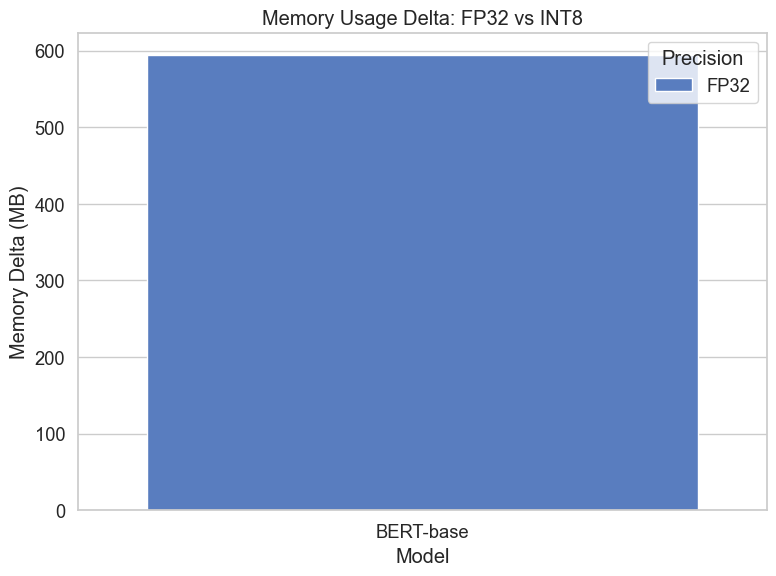

In [20]:
# 3. Memory Usage Delta
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x="Model", y="Memory_MB", hue="Quantized")
plt.title("Memory Usage Delta: FP32 vs INT8")
plt.ylabel("Memory Delta (MB)")
plt.legend(title="Precision")
plt.tight_layout()
plt.savefig("memory_comparison.png", dpi=300)
plt.show()

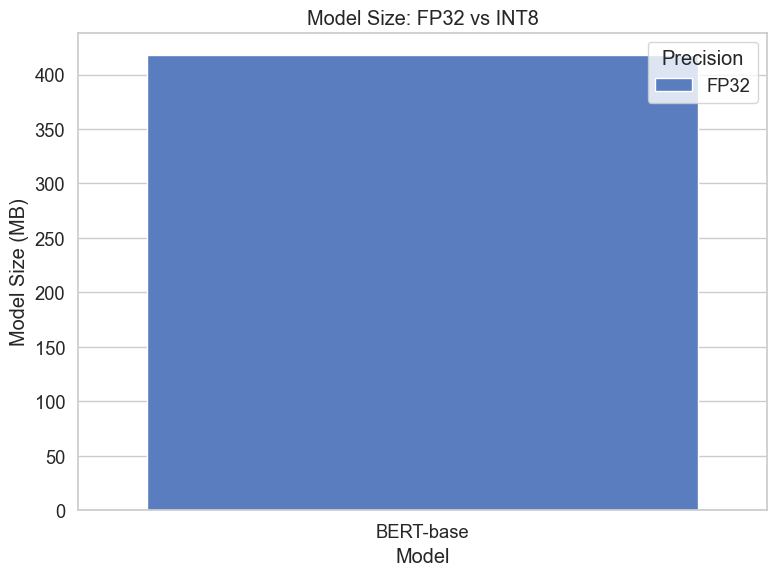

In [21]:
# 4. Model Size
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x="Model", y="ModelSize_MB", hue="Quantized")
plt.title("Model Size: FP32 vs INT8")
plt.ylabel("Model Size (MB)")
plt.legend(title="Precision")
plt.tight_layout()
plt.savefig("model_size_comparison.png", dpi=300)
plt.show()

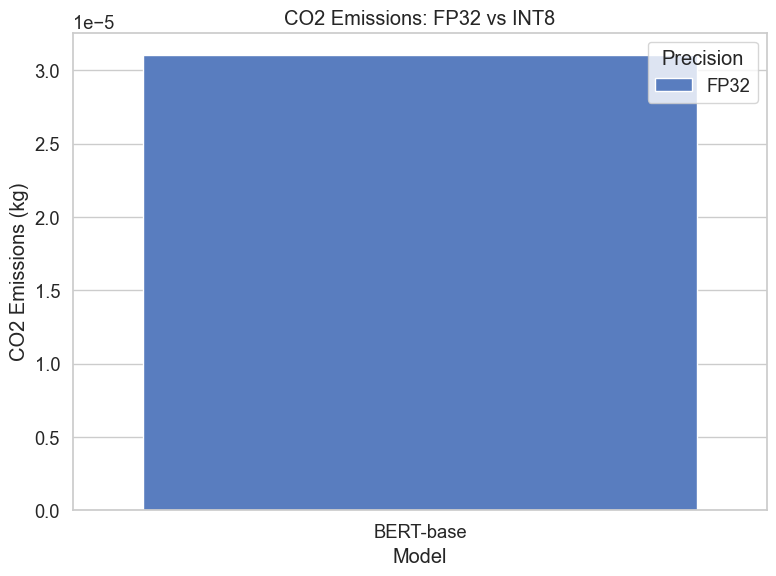

In [22]:
# 5. Emissions Comparison
plt.figure(figsize=(8, 6))
sns.barplot(data=df, x="Model", y="Emissions_kg", hue="Quantized")
plt.title("CO2 Emissions: FP32 vs INT8")
plt.ylabel("CO2 Emissions (kg)")
plt.legend(title="Precision")
plt.tight_layout()
plt.savefig("emissions_comparison.png", dpi=300)
plt.show()

In [ ]:
# 6. Accuracy vs Latency Trade-off
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="Latency_ms", y="Accuracy", hue="Model", style="Quantized", s=200, palette="deep")
plt.title("Trade-off: Accuracy vs Latency")
plt.xlabel("Latency (ms/sample)")
plt.ylabel("Accuracy")
plt.legend(title="Model / Precision")
plt.tight_layout()
plt.savefig("accuracy_vs_latency.png", dpi=300)
plt.show()

In [24]:
# 7-8. Radar Charts: BERT-base and DistilBERT
def radar_chart(df, model_name):
    metrics = ["Accuracy", "Latency_ms", "Memory_MB", "ModelSize_MB", "Emissions_kg"]
    df_norm = df[df["Model"] == model_name].copy()
    for m in metrics:
        if m == "Accuracy":
            df_norm[m] = df_norm[m] / df_norm[m].max()
        else:
            df_norm[m] = 1 / (df_norm[m] / df_norm[m].min())  # Invert for 'better' direction
    categories = metrics
    N = len(categories)
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
    angles += angles[:1]
    
    plt.figure(figsize=(8, 8))
    ax = plt.subplot(111, polar=True)
    for _, row in df_norm.iterrows():
        values = row[categories].values.flatten().tolist()
        values += values[:1]
        ax.plot(angles, values, linewidth=2, label=row["Quantized"])
        ax.fill(angles, values, alpha=0.25)
    plt.xticks(angles[:-1], categories, size=12)
    plt.title(f"Multi-Metric Efficiency: {model_name}", size=14)
    plt.legend(loc="upper right", bbox_to_anchor=(0.1, 0.1))
    plt.tight_layout()
    plt.savefig(f"radar_{model_name.lower()}.png", dpi=300)
    plt.show()

radar_chart(df, "BERT-base")
radar_chart(df, "DistilBERT")

KeyError: 'Latency_ms'

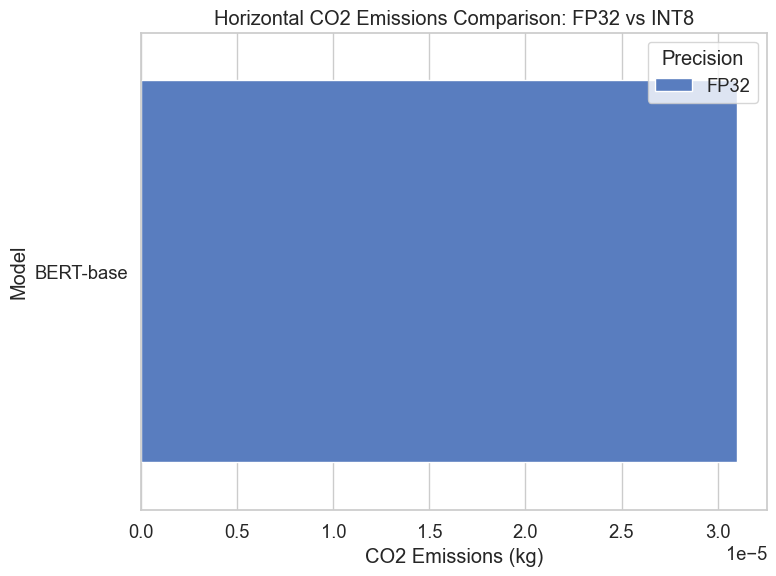

In [25]:
# 9. Horizontal Emissions Comparison
plt.figure(figsize=(8, 6))
sns.barplot(data=df, y="Model", x="Emissions_kg", hue="Quantized", orient="h")
plt.title("Horizontal CO2 Emissions Comparison: FP32 vs INT8")
plt.xlabel("CO2 Emissions (kg)")
plt.ylabel("Model")
plt.legend(title="Precision")
plt.tight_layout()
plt.savefig("emissions_horizontal.png", dpi=300)
plt.show()

In [26]:
# 10. Emissions Reduction Percentage
df_pivot = df.pivot(index="Model", columns="Quantized", values="Emissions_kg")
df["Emissions_Reduction_Pct"] = ((df_pivot["FP32"] - df_pivot["INT8"]) / df_pivot["FP32"] * 100).reset_index(drop=True)
df_int8 = df[df["Quantized"] == "INT8"]
plt.figure(figsize=(8, 6))
sns.barplot(data=df_int8, x="Model", y="Emissions_Reduction_Pct")
plt.title("Percentage Reduction in CO2 Emissions with INT8")
plt.ylabel("Reduction (%)")
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig("emissions_reduction_pct.png", dpi=300)
plt.show()

KeyError: 'INT8'

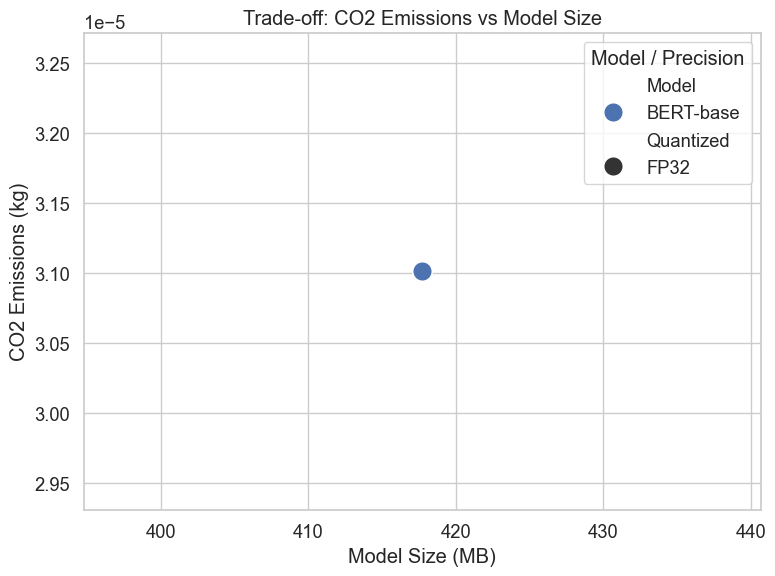

In [27]:
# 11. Emissions vs Model Size Trade-off
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x="ModelSize_MB", y="Emissions_kg", hue="Model", style="Quantized", s=200, palette="deep")
plt.title("Trade-off: CO2 Emissions vs Model Size")
plt.xlabel("Model Size (MB)")
plt.ylabel("CO2 Emissions (kg)")
plt.legend(title="Model / Precision")
plt.tight_layout()
plt.savefig("emissions_vs_size.png", dpi=300)
plt.show()

In [31]:
# --- Save Notebook ---
path = "/Users/phionanamugga/Documents/coding/datascience/Thesis/transformer_quantisation.ipynb"
try:
    nb = nbformat.read(path, as_version=4)
    if "widgets" in nb.metadata:
        del nb.metadata["widgets"]
    nbformat.write(nb, path)
    print("Notebook saved successfully.")
except Exception as e:
    print(f"Error saving notebook: {e}")



Error saving notebook: name 'nbformat' is not defined
